# 六分鐘運動肺功能自動判讀程式

## 單機版 v1.1

In [80]:
import os
import io
import PIL
from PIL import Image
import fitz
import pdfplumber
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import display
import PySimpleGUI as sg
import csv
import re
import docx
from docx.shared import RGBColor
from docx.shared import Cm, Pt  #加入可調整的 word 單位
from docx.oxml.ns import qn
from docx.enum.text import WD_ALIGN_PARAGRAPH #處理字串的置中

### 1. 擷取肺功能資料

### * DataFrame for Basic Data

In [81]:
pdf_dir = input('Please enter PFT folder name: ')
# pdf_dir = r'C:\Users\drcho\OneDrive\文件\Python Files\6MWT\programs\PFT_pdf files'
pdf_name = input('Please enter PFT filename: ')
pdf_data_dir = input(r'Please enter data reading folder ')
# pdf_data_dir = r'C:\Users\drcho\OneDrive\文件\Python Files\6MWT\programs\data_pdf files'
data_dir = input('Please enter the folder name for saving data ')
# data_dir = r'C:\Users\drcho\OneDrive\文件\Python Files\6MWT\programs\data_saving'
im_dir = input('Please input image folder: ')
# im_dir =r'C:\Users\drcho\OneDrive\文件\Python Files\6MWT\programs\Images_6mwt'

pdf = pdfplumber.open(r"{}\{}.pdf".format(pdf_dir, pdf_name))
# pdf = pdfplumber.open(r"C:\Users\drcho\OneDrive\文件\Python Files\6MWT\Vitagraph PDFs\廖淑瑛_16885750_20210513134300.pdf".format(pdf_name))
page_0 = pdf.pages[0]
page_1 = pdf.pages[1]

In [82]:
# for basic data
table_0 = page_0.extract_tables()
columns_basic_data = ['Chart No.', 'Name', 'Birthday', "Age", 'Gender', 'BMI', 'Test-date']
basic_data = [[table_0[0][1][3], table_0[0][1][1], table_0[0][2][3], int(table_0[0][3][1]), table_0[0][4][1]
, float(table_0[0][5][1]), table_0[1][1][1].split(' ')[0]]]
bdata_df = pd.DataFrame(basic_data, columns=columns_basic_data)

In [83]:
print(bdata_df)

  Chart No. Name    Birthday  Age  Gender   BMI   Test-date
0  18189805  蔡美玲  06/06/1959   61  Female  22.8  06/05/2021


### * DataFrame for PFT

In [84]:
table_1 = page_1.extract_table()
columns_new = [item.replace('\n', '-') for item in table_1[1]]
# lst_n =[]
for lst in table_1[2:18]:
    for n in range(1, len(table_1[2])):
        try: 
            lst[n]=float(lst[n].replace('*', ''))
        except ValueError:
            lst[n]=lst[n].replace('*', '')


pft_df = pd.DataFrame(table_1[2:18], columns=columns_new)
pft_df

,Parameter,Pred,Pre-Best,% Pre-Pred,Post-Best,%Post Pred.,% Pre-Post
0,FVC (L),2.35,1.70,72.0,1.68,71.0,-1.2
1,FEV1 (L),1.96,1.05,54.0,1.04,53.0,-1.0
2,FEV1/FVC,0.78,0.62,79.0,0.62,79.0,0.0
3,FEV6 (L),2.35,1.70,72.0,1.68,71.0,-1.2
4,PEF (L/min),332.00,200.00,60.0,217.00,65.0,8.5
5,FEF25-75 (L/s),2.77,0.58,21.0,0.57,21.0,-1.7
6,FEF75-85 (L/s),0.32,0.24,75.0,0.24,75.0,0.0
7,FEF25 (L/s),5.03,1.47,29.0,1.35,27.0,-8.2
8,FEF50 (L/s),3.41,0.68,20.0,0.65,19.0,-4.4
9,FEF75 (L/s),1.20,0.32,27.0,0.33,28.0,3.1


In [85]:
pft_df_n = pft_df.set_index("Parameter")
pft_df_n
new_row = ['FVC (L)',
 'FEV1 (L)',
 'FEV1/FVC',
 'PEF (L/min)',
 'FEF25-75 (L/s)',
 'FIVC (L)',
 'FIVC/FVC',
 'TV (L)',
 'IC (L)']
pft_df_n = pft_df_n.loc[new_row, :]
pft_df_n
# print(pft_df_n.stack())
# pft_df_n.T.stack()

,Pred,Pre-Best,% Pre-Pred,Post-Best,%Post Pred.,% Pre-Post
Parameter,,,,,,
FVC (L),2.35,1.70,72.0,1.68,71.0,-1.2
FEV1 (L),1.96,1.05,54.0,1.04,53.0,-1.0
FEV1/FVC,0.78,0.62,79.0,0.62,79.0,0.0
PEF (L/min),332.00,200.00,60.0,217.00,65.0,8.5
FEF25-75 (L/s),2.77,0.58,21.0,0.57,21.0,-1.7
FIVC (L),2.35,1.76,75.0,1.71,73.0,-2.8
FIVC/FVC,1.00,1.04,104.0,1.02,102.0,-2.0
TV (L),--,0.98,--,1.53,--,56.1
IC (L),1.86,1.35,73.0,1.57,84.0,16.3


### * Transforming shape of DataFrame

In [86]:
pre_best = list(pft_df_n['Pre-Best'])
pre_pred_p = list(pft_df_n['% Pre-Pred'])
post_best = list(pft_df_n['Post-Best'])
columns_name = list(pft_df_n.index)
column_pre = ["Pre-"+ name for name in columns_name]
column_pred = [r"%Pred "+ name.split(' ')[0] for name in columns_name]
column_post = ["Post-"+ name for name in columns_name]
columns_new = column_pre + column_pred + column_post
data_lst = pre_best+pre_pred_p+post_best

data_lst_lst =[]
for item in data_lst:
    data_lst_lst.append([item])

data_dict = dict(zip(columns_new, data_lst_lst))
pft_df_nn = pd.DataFrame.from_dict(data_dict)
pft_df_nn.insert(0, 'Chart No.', bdata_df['Chart No.'])
pft_df_nn['Test-date'] = bdata_df['Test-date']
pft_df_nn

,Chart No.,Pre-FVC (L),Pre-FEV1 (L),Pre-FEV1/FVC,Pre-PEF (L/min),Pre-FEF25-75 (L/s),Pre-FIVC (L),Pre-FIVC/FVC,Pre-TV (L),Pre-IC (L),...,Post-FVC (L),Post-FEV1 (L),Post-FEV1/FVC,Post-PEF (L/min),Post-FEF25-75 (L/s),Post-FIVC (L),Post-FIVC/FVC,Post-TV (L),Post-IC (L),Test-date
0,18189805,1.7,1.05,0.62,200.0,0.58,1.76,1.04,0.98,1.35,...,1.68,1.04,0.62,217.0,0.57,1.71,1.02,1.53,1.57,06/05/2021


### *Crop flow-volume curve

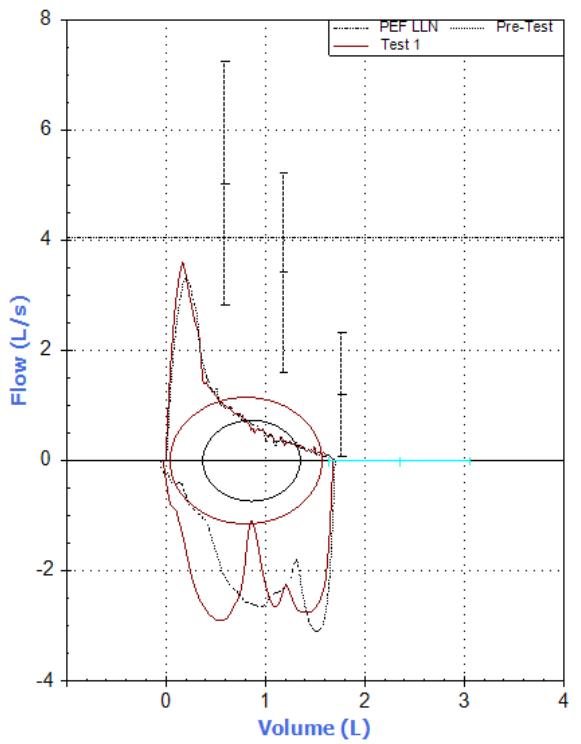

In [87]:
# re-open PDF for flow-volume-curve cropping
pdf_2 = fitz.open(r"{}\{}.pdf".format(pdf_dir, pdf_name))

page_0 = pdf_2.loadPage(0)
zoom_x = 2.0  # horizontal zoom
zomm_y = 2.0  # vertical zoom
mat = fitz.Matrix(zoom_x, zomm_y)  # zoom factor 2 in each dimension
pix_0 = page_0.get_pixmap(matrix=mat)  # use 'mat' instead of the identity matrix
pix_0.writePNG(r'{}\{}.png'.format(im_dir, pdf_name))
image_0 = Image.open(r'{}\{}.png'.format(im_dir, pdf_name))
copy_image_c = image_0.copy()
flow_volume_curve = copy_image_c.crop((305,602,886,1346))
display(flow_volume_curve)

### *利用DataFrame中的病歷號資料為檔案名稱，儲存資料 (csv and xlsx)
### _01 基本資料 _02 詳細肺功能結果  _fvc.png Flow-Volume-Curve 圖檔

In [88]:
# 利用DataFrame中的病歷號資料為檔案名稱，儲存資料 
# _01 基本資料 _02 詳細肺功能結果

flow_volume_curve.save(r'{}\{}_fvc.png'.format(im_dir, bdata_df.iloc[0,0]))
bdata_df.to_excel(r'{}\{}_01.xlsx'.format(data_dir, bdata_df.iloc[0,0]), index=False)
bdata_df.to_csv(r'{}\{}_01.csv'.format(data_dir, bdata_df.iloc[0,0]), index=False)
pft_df_nn.to_excel(r'{}\{}_02.xlsx'.format(data_dir, bdata_df.iloc[0,0]), index=False)
pft_df_nn.to_csv(r'{}\{}_02.csv'.format(data_dir, bdata_df.iloc[0,0]), index=False)


### 2. Auto-input parameters

In [89]:
# file_name = input('Please input Chart No.')
df_1 = pd.read_excel(r'{}\{}_01.xlsx'.format(data_dir, bdata_df.iloc[0,0]))
df_2 = pd.read_excel(r'{}\{}_02.xlsx'.format(data_dir, bdata_df.iloc[0,0]))

In [90]:
# report_file_name = input(r'Please input report docx file name ')
report_file_name_1 = re.findall('_([0-9.]+)', pdf_name)
report_file_name = report_file_name_1[0] +'-'+ report_file_name_1[1][0:8]
# print(report_file_name)
pdf_data_01 = pdfplumber.open(f"{pdf_data_dir}\{bdata_df.iloc[0,0]}.pdf")
pdf_data_02 = pdfplumber.open(f"{pdf_data_dir}\{report_file_name}.pdf")
pdf_data_01_im = fitz.open(f"{pdf_data_dir}\{bdata_df.iloc[0,0]}.pdf")

In [91]:
page_data_01_im_02 = pdf_data_01_im[1]
images_data_01_im = page_data_01_im_02.getImageList()

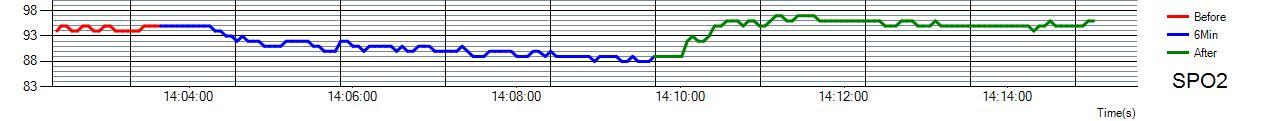

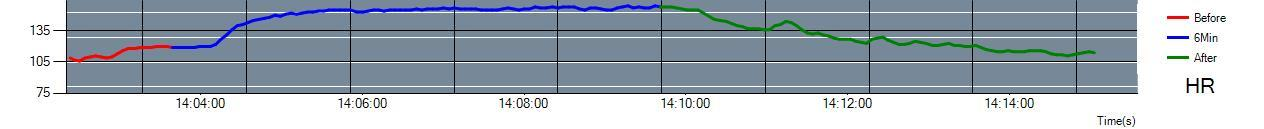

In [92]:
# xref 存在於每一個image的第一項
xref_0 = images_data_01_im[0][0]
xref_1 = images_data_01_im[1][0]
# 利用 pdf.extractImage(xref) 取得base_image
base_image_0 = pdf_data_01_im.extractImage(xref_0)
base_image_1 = pdf_data_01_im.extractImage(xref_1)
# base_image composed of 1. image_bytes ["image"] and 2. image_ext ["ext"]
image_bytes_0 = base_image_0["image"]
image_bytes_1 = base_image_1['image']
image_ext_0 = base_image_0["ext"]  #其實type(image)就可以知道 image ext
image_oxy = Image.open(io.BytesIO(image_bytes_0))
image_hr = Image.open(io.BytesIO(image_bytes_1))
display(image_oxy)
display(image_hr)
# print(image_ext_0)
# print(type(image_oxy))

In [93]:
image_oxy.save(r'{}\{}_oxy.png'.format(im_dir, bdata_df.iloc[0,0]))
image_hr.save(r'{}\{}_hr.png'.format(im_dir, bdata_df.iloc[0,0]))

In [94]:
pages_data_01 = pdf_data_01.pages

tables_data_01_01 = pages_data_01[0].extract_tables()
tables_data_01_02 = pages_data_01[1].extract_tables()
for n in range(len(tables_data_01_02[2])):
    if tables_data_01_02[2][0][n] == "脈動率(HR)":
        HR_n = n
HR_n


1

In [95]:
pages_data_02 = pdf_data_02.pages

tables_data_02_01 = pages_data_02[0].extract_tables()
# tables_data_02_01
for n in range(len(tables_data_02_01)):
    if tables_data_02_01[n][0][0].split()[0] == 'Six-minute':
        specific_n = n
# tables_data_02_01[1][0]

In [96]:
ex_limit = input("Was excercise limited?(Y/N)")
if ex_limit == 'Y':
    limit_choice = int(input(r"(0) No limitation (1) Muscle weakness (2) Breathless (3) Unstable gait (4) Unwilling to walk further (5) Pain on walking (6) Chest tightness (7) Dizziness (8) Others (1~8)"))
else: limit_choice = 0   
TV_encroach_b = input("Tidal loop encroaching?(before)(Y/N) ")
TV_encroach_a = input("Tidal loop encroaching?(after)(Y/N) ")
distance = int(re.findall('([0-9]+)', tables_data_02_01[specific_n][0][0])[0])
HR_b = int(re.findall('([0-9]+)', tables_data_02_01[specific_n][1][1])[0])
HR_M = int(re.findall('([0-9]+)', tables_data_02_01[specific_n][1][2])[0])
HR_a = int(re.findall('([0-9]+)', tables_data_01_02[2][1][HR_n])[0])
oxy_a = int(re.findall('([0-9]+)', tables_data_01_02[2][1][0])[0])
oxy_b = int(re.findall('([0-9]+)', tables_data_02_01[specific_n][3][1])[0])
oxy_m = int(re.findall('([0-9]+)', tables_data_02_01[specific_n][3][2])[0])
borg_b = int(re.findall('([0-9]+)', tables_data_02_01[specific_n][4][1])[0])
borg_a = int(re.findall('([0-9]+)', tables_data_02_01[specific_n][4][2])[0])

In [97]:
input_vari = {
    'ex_limit': ex_limit,
    'limit_choice': limit_choice,
    'borg_b': borg_b, 
    'borg_a': borg_a, 
    'HR_b': HR_b, 
    'HR_a': HR_a, 
    'HR_M': HR_M, 
    'oxy_b': oxy_b, 
    'oxy_a': oxy_a,
    'oxy_m': oxy_m, 
    'TV_encroach_b': TV_encroach_b, 
    'TV_encroach_a': TV_encroach_a, 
    'distance': distance}
df_3 = pd.Series(input_vari)
df_3

ex_limit           N
limit_choice       0
borg_b             0
borg_a             3
HR_b             109
HR_a             129
HR_M             159
oxy_b             94
oxy_a             94
oxy_m             88
TV_encroach_b      Y
TV_encroach_a      Y
distance         508
dtype: object

### *儲存檔案 _3 生理參數

In [98]:
df_3.to_excel(r'{}\{}_03.xlsx'.format(data_dir, bdata_df.iloc[0,0]))
df_3.to_csv(r'{}\{}_03.csv'.format(data_dir, bdata_df.iloc[0,0]))

In [99]:
df_3 = pd.read_excel(r'{}\{}_03.xlsx'.format(data_dir, bdata_df.iloc[0,0]))
df_3 = df_3.rename(columns={'Unnamed: 0' : "parameter", 0 :'data'})
df_3 = df_3.set_index('parameter')

In [100]:
df_3

,data
parameter,
ex_limit,N
limit_choice,0
borg_b,0
borg_a,3
HR_b,109
HR_a,129
HR_M,159
oxy_b,94
oxy_a,94


In [101]:
# 計算後的參數
target_HR = int((220-int(df_1['Age'][0]))*0.7)
Oxy_delta = int(df_3['data']['oxy_m'] - df_3['data']['oxy_b'])
IC_delta = round(df_2['Post-IC (L)'][0] - df_2['Pre-IC (L)'][0], 2)
IRV_pre = round(df_2['Pre-IC (L)'][0] - df_2['Pre-TV (L)'][0], 2)
IRV_post = round(df_2['Post-IC (L)'][0] - df_2['Post-TV (L)'][0], 2)
IRV_post
ERV_pre = round(df_2['Pre-FVC (L)'][0] - df_2['Pre-IC (L)'][0], 2)
ERV_post = round(df_2['Post-FVC (L)'][0] - df_2['Post-IC (L)'][0], 2)
TV_delta = round(df_2['Post-TV (L)'][0] - df_2['Pre-TV (L)'][0], 2)

In [102]:
cal_vari = {
    'target_HR': target_HR,
    'Oxy_delta': Oxy_delta,
    'IC_delta': IC_delta,
    'IRV_pre': IRV_pre,
    'IRV_post': IRV_post,
    'ERV_pre': ERV_pre,
    'ERV_post': ERV_post,
    'TV_delta': TV_delta}

### *儲存檔案 _04 計算後的參數

In [103]:
df_4 = pd.Series(cal_vari)
df_4.to_excel(r'{}\{}_04.xlsx'.format(data_dir, bdata_df.iloc[0,0]))
df_4.to_csv(r'{}\{}_04.csv'.format(data_dir, bdata_df.iloc[0,0]))

In [104]:
df_4 = pd.read_excel(r'{}\{}_04.xlsx'.format(data_dir, bdata_df.iloc[0,0]))
df_4 = df_4.rename(columns={'Unnamed: 0' : "parameter", 0 :'data'})
df_4 = df_4.set_index('parameter')
df_4

,data
parameter,
target_HR,111.00
Oxy_delta,-6.00
IC_delta,0.22
IRV_pre,0.37
IRV_post,0.04
ERV_pre,0.35
ERV_post,0.11
TV_delta,0.55


### 3. 建立報告正文

In [105]:
# Text for report
text00 = 'Exercise was not limited.'
text0 = 'Exercise was limited by {}'
text1 = 'The Patient walked {}M in 6 min at his/her fastest speed.'
text2 = 'Borg’s scale changed from {} at rest to {} after exercise.'
text3 = r'Oxygenation changed from {}% before to {}% after exercise at nadir {}%'
text4 = r'Heart rate changed from {}/bpm to {}/bpm after exercise, peak heart rate at {}/bpm. (Target heart rate {}/bpm)'
text_main = 'The exercise test is {} performed. Exercise capacity is {} for normal daily activities. During exercise, there was {} desaturation, {} tidal loop encroaching, and the tidal loop was found {}, tidal volume {}, IC {} after exercise.'

In [106]:
# word dictionary for text
dic_words = {
    "ex_limit": ["No limitation"
    , "Muscle Weakness"
    , "Breathless"
    , "Ustable gait"
    , "Unwilling to walk further"
    , "Pain on walking"
    , "Chest tightness"
    , "Dizziness"
    , "Others"],
    "ex_test": ["adequately"
    , "inadequately"],
    "ex_capacity": ["insufficient"
    , "equivocal"
    , "adequate"
    , "exceeding demand"],
    "ex_desaturation": [""
    , "no"],
    "ex_encroaching": ["with"
    , "without"],
    "ex_shifting": ["not shifted"
    , "shifted to right"
    , "shifted to left"],
    "tidal_vol": ["decreased"
    , "increased"
    , "no changed"],
    "IC": ["decreased"
    , "increased"
    , "no change"]}

In [107]:
# functions for word selection
def ex_test(int1, int2):
    if int1 > int2:
        result = 1
    else:
        result = 0
    return result


def ex_cap(int):
    if int >= 500:
        result = 3
    elif int >= 450:
        result = 2
    elif int >= 300:
        result = 1
    else:
        result = 0
    return result


def desat(int):
    if int > -4:
        result = 1
    else:
        result = 0
    return result


def encroah(c):
    if c == 'Y':
        result = 0
    else:
        result = 1
    return result


def t_v(int):
    if int < 0:
        result = 0
    elif int > 0:
        result = 1
    else:
        result = 2
    return result


def i_c(int):
    if int < 0:
        result = 0
    elif int > 0:
        result = 1
    else:
        result = 2
    return result


def shift(int1, int2, int3, int4):
    if (int1 > int2) and (int3 < int4):
        result = 2
    elif (int1 < int2) and (int3 > int4):
        result = 1
    else:
        result = 0
    return result


### 報告建立完成

In [108]:
if ex_limit == 'N':
    r_0 = text00
else: 
    r_0 = text0.format(dic_words["ex_limit"][limit_choice])
r_1 = text1.format(int(distance))
r_2 = text2.format(borg_b, borg_a)
r_3 = text3.format(oxy_b, oxy_a, oxy_m)
r_4 = text4.format(HR_b, HR_a, HR_M, target_HR)
r_main = text_main.format(dic_words["ex_test"][ex_test(target_HR, HR_M)], dic_words['ex_capacity'][ex_cap(int(distance))]
, dic_words["ex_desaturation"][desat(Oxy_delta)], dic_words['ex_encroaching'][encroah(TV_encroach_a)]
, dic_words["ex_shifting"][shift(IRV_pre, IRV_post, ERV_pre, ERV_post)], dic_words['tidal_vol'][t_v(TV_delta)]
, dic_words["IC"][i_c(IC_delta)])

In [109]:
print(r_0)
print(r_1)
print(r_2)
print(r_3)
print(r_4)
print(r_main)

Exercise was not limited.
The Patient walked 508M in 6 min at his/her fastest speed.
Borg’s scale changed from 0 at rest to 3 after exercise.
Oxygenation changed from 94% before to 94% after exercise at nadir 88%
Heart rate changed from 109/bpm to 129/bpm after exercise, peak heart rate at 159/bpm. (Target heart rate 111/bpm)
The exercise test is adequately performed. Exercise capacity is exceeding demand for normal daily activities. During exercise, there was  desaturation, with tidal loop encroaching, and the tidal loop was found not shifted, tidal volume increased, IC increased after exercise.


### 4. 專業判讀

In [31]:
# Load DataFrame
# df_1 = pd.read_excel(r'{}\{}_01.xlsx'.format(data_dir, bdata_df.iloc[0,0]))
# df_2 = pd.read_excel(r'{}\{}_02.xlsx'.format(data_dir, bdata_df.iloc[0,0]))
# df_3 = pd.read_excel(r'{}\{}_03.xlsx'.format(data_dir, bdata_df.iloc[0,0]))
# df_3 = df_3.rename(columns={'Unnamed: 0' : "parameter", 0 :'data'})
# df_3 = df_3.set_index('parameter')
# df_4 = pd.read_excel(r'{}\{}_04.xlsx'.format(data_dir, bdata_df.iloc[0,0]))
# df_4 = df_4.rename(columns={'Unnamed: 0' : "parameter", 0 :'data'})
# df_4 = df_4.set_index('parameter')

In [110]:
# dictionaries for interpretation

dic_int = {
    "Normal": ["Dynamic air-trapping, small airway diseases"
    , "intra- or extrapulmonary restrictive ventilatory impairment"
    , "Nasal blockade or upper airway dysfunction"
    , "Non-diaphragmatic breathing"
    , "increased closing volume, abdominal distension, smoker"
    , "Early stage of interstitial lung disease, heart failure, arrhythmia, muscle weakness"
    , "Normal"],
    "Suspected small airway disease": ["small airway diseases"
    , "intra- or extrapulmonary restrictive ventilatory impairment"
    , "Nasal blockade or upper airway dysfunction"
    , "Non-diaphragmatic breathing"
    , "increased closing volume, abdominal distension, smoker"
    , "Early stage of interstitial lung disease, heart failure, arrhythmia, muscle weakness"
    , "Normal"],
    "Restrictive": ["Dynamic air-trapping, small airway diseases"
    , "intra- or extrapulmonary restrictive ventilatory impairment"
    , "c/w Nasal blockade or upper airway dysfunction"
    , "c/w Non-diaphragmatic breathing"
    , "c/w increased closing volume"
    , "Early stage of interstitial lung disease, heart failure, arrhythmia, muscle weakness"
    , "Adequate enlarging tidal volume"],
    "Obstructive": ["Dynamic air-trapping, Obstructive ventilatory impairment such as COPD or Asthma"
    , "Obstructive impairment c/w restrictive ventilator impairment"
    , "Obstructive ventilatory impairment c/w  large airway dysfunction"
    , "Obstructive ventilatory impairment c/w nasal blockade or upper airway dysfunction"
    , "Obstructive ventilatory impairment c/w Non-diaphragmatic breathing"
    , "Obstructive ventilatory impairment c/w increased closing volume"
    , "Adequate enlarging tidal volume"]}

dynamic_collapse = ['Before and after walking, ', 'Before walking, ', 'After walking, ', 'No']

dic_relevant = {
    'Normal' : {
        "Medication": ["Long-acting bronchodilators (LABA or LABA+ LAMA)"
        , "Treat underlying"
        , "Nasal decongestants, Nasal topical corticosteroids, Surgery"
        , "No suggestion"
        , "LABA"
        , "Treat underlying"
        , "No suggestion"],
        "Rehabilitation": ["Purse-lip breathing, PEP"
        , "Expansion therapy: NPV for intrapulmonary, BIPAP for extrapulmonary lesions"
        , "Regular exercise"
        , "Breathing control, diaphragmatic breathing re-training"
        , "Positive pressure ventilation"
        , "Explore upper airway dysfunction"
        , "Regular exercise"]}, 
    'Suspected small airway disease' : {
        "Medication": ["Long-acting bronchodilators (LABA or LABA+ LAMA)"
        , "Treat underlying"
        , "Nasal decongestants, Nasal topical corticosteroids, Surgery"
        , "No suggestion"
        , "LABA"
        , "Treat underlying"
        , "No suggestion"],
        "Rehabilitation": ["Purse-lip breathing, PEP"
        , "Expansion therapy: NPV for intrapulmonary, BIPAP for extrapulmonary lesions"
        , "Regular exercise"
        , "Breathing control, diaphragmatic breathing re-training"
        , "Positive pressure ventilation"
        , "Explore upper airway dysfunction"
        , "Regular exercise"]}, 
    'Obstructive' : {
        "Medication": ["Long-acting bronchodilators (LABA or LABA+ LAMA)"
        , "Long-acting bronchodilators (LABA or LABA+ LAMA)"
        , "Long-acting bronchodilators (LABA or LABA+ LAMA)"
        , "Long-acting bronchodilators (LABA or LABA+ LAMA) + Nasal decongestants, Nasal topical corticosteroids, Surgery"
        , "Long-acting bronchodilators (LABA or LABA+ LAMA)"
        , "Long-acting bronchodilators (LABA or LABA+ LAMA)"
        , "No suggestion"],
        "Rehabilitation": ["Purse-lip breathing, PEP, Positive pressure ventilation"
        , "Expansion therapy: NPV for intrapulmonary, BIPAP for extrapulmonary lesions"
        , "Explore upper airway dysfunction"
        , "Explore upper airway dysfunction"
        , "Breathing control, diaphragmatic breathing re-training"
        , "Purse-lip breathing, PEP"
        , "Regular exercise"]},
    'Restrictive' : {
        "Medication": ["Long-acting bronchodilators (LABA or LABA+ LAMA)"
        , "Treat underlying"
        , "Nasal decongestants, Nasal topical corticosteroids, Surgery"
        , "No suggestion"
        , "LABA"
        , "Treating underlying"
        , "No suggestion"],
        "Rehabilitation": ["Purse-lip breathing, PEP, Positive pressure ventilation"
        , "Expansion therapy: NPV for intrapulmonary, BIPAP for extrapulmonary lesions"
        , "Explore upper airway dysfunction"
        , "Breathing control, diaphragmatic breathing re-training"
        , "Purse-lip breathing, PEP"
        , "Regular exercise"
        , "Regular exercise"]}}

### *function for spirometry pattern interpretation

In [111]:
def PFT_type(data):
    if data['Pre-FEV1/FVC'][0] >= 0.75:
        if data['%Pred FVC'][0] >= 80:
            if data['%Pred FEF25-75'][0] >= 60:
                result = 'Normal'
            else:
                result = 'Suspected small airway disease'
        else:
            result = 'Restrictive'
    else:
        result = 'Obstructive'
    # elif data['FEV1/FVC'][0] >= 0.6:
    #     result = 'Mild Obstruction'
    # elif data['FEV1/FVC'][0] >= 0.4:
    #     result = 'Moderate Obstruction'
    # else:
    #     result = 'Severe Obstruction'
    return result

### *function for dynamic large airway collapse

In [112]:
dynamic_collapse = ['Before and after walking, ', 'Before walking, ', 'After walking, ', 'No']

def dynamic_c(data):
    if data['data']['TV_encroach_b'] == "Y":
        if data['data']['TV_encroach_a'] == "Y":
            dc = 0
        else:
            dc = 1
    else:
        if data['data']['TV_encroach_a'] == "Y":
            dc = 2
        else:
            dc = 3
    return dc

### *functions for complicated interpretation

In [113]:
def six_norm(data):
    if data['data']['IC_delta'] < 0 :                     # decreased delta IC
        if data['data']['IRV_post'] < data['data']['IRV_pre']: # recruit IRV(+)
            result = 1
        else:                                       # recruit IRV(-)
            if data['data']['ERV_post'] >= data['data']['ERV_pre']:    # recruit ERV(-)
                result = 2
                    
    elif data['data']['Oxy_delta'] >= -3:                      # no change delta IC and no O2 down
        if data['data']['IRV_post'] >= data['data']['IRV_pre']:        # recruit IRV(-)
            if data['data']['ERV_post'] < data['data']['ERV_pre']:     # recruit ERV(+)
                if data['data']['TV_delta'] >= 0:                   # increased TV
                    result = 3
                else:
                    result = 4
        else:                                               # recruit IRV(+)
            if data['data']['ERV_post'] >= data['data']['ERV_pre']:    # recruit ERV(-)
                result = 5
            else:
                result = 7
    elif data['data']['Oxy_delta'] < -3:                           # no change delta IC and O2 down
        result = 6
    return result


def six_rest(data):
    if data['data']['IC_delta'] < 0 :                            # decreased delta IC
        if data['data']['IRV_post'] < data['data']['IRV_pre']:             # recruit IRV(+)
            result = 1
        else:
            result = 2
        
    elif data['data']['Oxy_delta'] >= -3 :                          # no change delta IC and no O2 down
        if data['data']['IRV_post'] >= data['data']['IRV_pre']:            # recruit IRV(-)
            if data['data']['ERV_post'] < data['data']['ERV_pre']:         # recruit ERV(+)
                if data['data']['TV_delta'] >= 0:
                    result = 3
                else:
                    result = 4
        else:                                               # recruit IRV(+)
            if data['data']['ERV_post'] > data['data']['ERV_pre']:            # recruit ERV(-)
                result = 5
            else:
                result = 7
    else:                                                   # no change delta IC and O2 down
        result = 6
    return result


def six_obs(data):
    if data['data']['IC_delta'] < 0 :                    # decreased delta IC
        if data['data']['IRV_post'] < data['data']['IRV_pre']:         # recruit IRV(+)
            result = 1
        elif data['data']['ERV_post'] >= data['data']['ERV_pre']:  # recruit ERV(-)
            result = 2
        else:
            result = 3
    elif data['data']['IRV_post'] >= data['data']['IRV_pre']:  # recruit IRV(-)
        if data['data']['ERV_post'] < data['data']['ERV_pre']:  # recruit ERV(+)
            if data['data']['Oxy_delta'] >= -3 :             # no desaturation
                result = 4
            else:
                result = 5
    else:
        result = 6
    return result


def six_min_pft(data1, data2):
    type = PFT_type(data1)
    if type == "Normal":
        inter = six_norm(data2)
    elif type == "Suspected small airway disease":
        inter = six_norm(data2)
    elif type == "Restrictive":
        inter = six_rest(data2)
    elif type == "Obstructive":
        inter = six_obs(data2)
    return (type, inter)

### *開始判讀

In [114]:
t, l = six_min_pft(df_2, df_4)
LADC = dynamic_c(df_3)

### Interpretation

In [115]:
inter_0 = r'(1) {} pattern at baseline'.format(t)
inter_1 = r'(2) {} dynamic large airway collapse'.format(dynamic_collapse[LADC])
inter_2 = r'(3) ' + dic_int[t][l-1]
print(inter_0)
print(inter_1)
print(inter_2)

(1) Obstructive pattern at baseline
(2) Before and after walking,  dynamic large airway collapse
(3) Obstructive ventilatory impairment c/w increased closing volume


### Clinical relevance

In [116]:
c_relevant_0 = r'Medications: ' + dic_relevant[t]['Medication'][l-1]
c_relevant_1 = r'Rehabilitation: ' + dic_relevant[t]['Rehabilitation'][l-1]
print(c_relevant_0)
print(c_relevant_1)

Medications: Long-acting bronchodilators (LABA or LABA+ LAMA)
Rehabilitation: Purse-lip breathing, PEP


# Complete Report

  Chart No. Name    Birthday  Age  Gender   BMI   Test-date
0  18189805  蔡美玲  06/06/1959   61  Female  22.8  06/05/2021


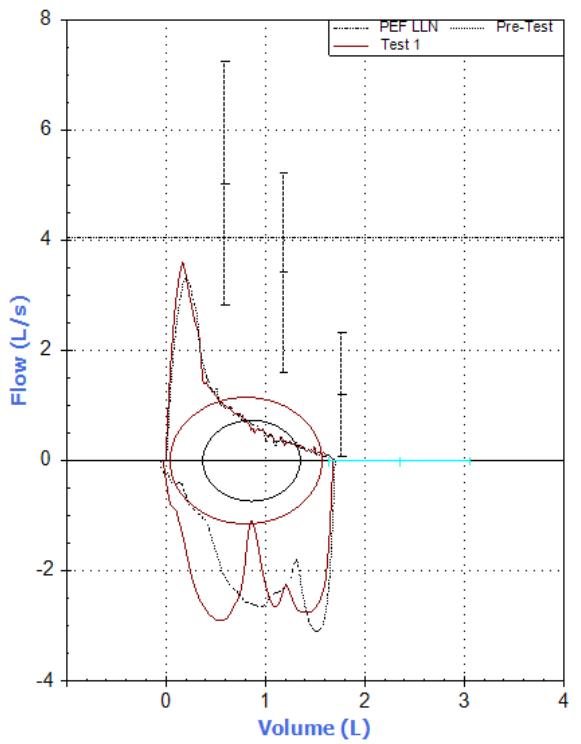

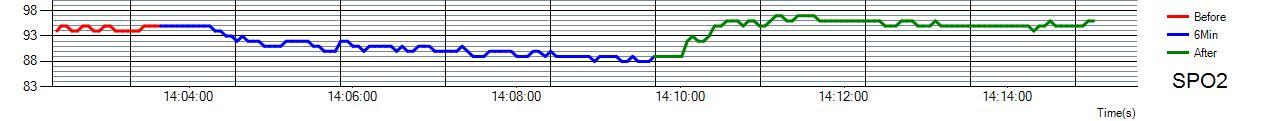

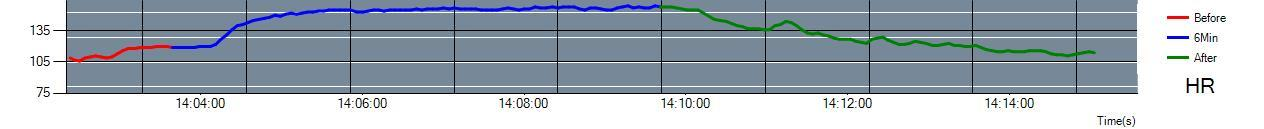

                  Pred Pre-Best % Pre-Pred Post-Best %Post Pred. % Pre-Post
Parameter                                                                  
FVC (L)           2.35     1.70       72.0      1.68        71.0       -1.2
FEV1 (L)          1.96     1.05       54.0      1.04        53.0       -1.0
FEV1/FVC          0.78     0.62       79.0      0.62        79.0        0.0
PEF (L/min)     332.00   200.00       60.0    217.00        65.0        8.5
FEF25-75 (L/s)    2.77     0.58       21.0      0.57        21.0       -1.7
FIVC (L)          2.35     1.76       75.0      1.71        73.0       -2.8
FIVC/FVC          1.00     1.04      104.0      1.02       102.0       -2.0
TV (L)              --     0.98         --      1.53          --       56.1
IC (L)            1.86     1.35       73.0      1.57        84.0       16.3
Exercise was not limited.
The Patient walked 508M in 6 min at his/her fastest speed.
Borg’s scale changed from 0 at rest to 3 after exercise.
Oxygenation changed fr

In [117]:
print(bdata_df)
display(flow_volume_curve)
display(image_oxy)
display(image_hr)
print(pft_df_n)
print(r_0)
print(r_1)
print(r_2)
print(r_3)
print(r_4)
print(r_main)
print('Interpretation:')
print(inter_0)
print(inter_1)
print(inter_2)
print('Clinical relevance')
print(c_relevant_0)
print(c_relevant_1)

# 匯出Word file

In [ ]:
# range(bdata_df.shape[-1])

In [ ]:
# pft_df_n.shape

In [118]:
head_line = r'運動肺功能檢查報告'

doc = docx.Document()
doc.add_heading(head_line, level=1)
t = doc.add_table(bdata_df.shape[0]+1, bdata_df.shape[1])
# add the header rows.
for j in range(bdata_df.shape[-1]):
    t.cell(0,j).text = bdata_df.columns[j]

# add the rest of the data frame
for i in range(bdata_df.shape[0]):
    for j in range(bdata_df.shape[-1]):
        t.cell(i+1,j).text = str(bdata_df.values[i,j])
doc.add_picture(r'{}\{}_fvc.png'.format(im_dir, bdata_df.iloc[0,0]), width=Cm(10))
doc.add_picture(r'{}\{}_oxy.png'.format(im_dir, bdata_df.iloc[0,0]), width=Cm(15))
doc.add_picture(r'{}\{}_hr.png'.format(im_dir, bdata_df.iloc[0,0]), width=Cm(15))
doc.add_page_break()
t_2 = doc.add_table(pft_df_n.shape[0]+1, pft_df_n.shape[1]-1)
# add the header rows.
for j in range(pft_df_n.shape[-1]-1):
    t_2.cell(0,j+1).text = pft_df_n.columns[j+1]
for i in range(pft_df_n.shape[0]):
    t_2.cell(i+1, 0).text = pft_df_n.index[i]

# # # add the rest of the data frame
for i in range(pft_df_n.shape[0]):
    for j in range(pft_df_n.shape[-1]-2):
        t_2.cell(i+1,j+1).text = str(pft_df_n.values[i,j+1])
# doc.add_paragraph(print(pft_df_n))
doc.add_paragraph("")
doc.add_paragraph(r_0)
doc.add_paragraph(r_1)
doc.add_paragraph(r_2)
doc.add_paragraph(r_3)
doc.add_paragraph(r_4)
doc.add_paragraph(r_main)
doc.add_heading("Interpretation", level=2)
doc.add_paragraph(inter_0)
doc.add_paragraph(inter_1)
doc.add_paragraph(inter_2)
doc.add_heading("Clinical relevant", level=2)
doc.add_paragraph(c_relevant_0)
doc.add_paragraph(c_relevant_1)
doc.save(r'C:\Users\drcho\OneDrive\文件\Python Files\6MWT\programs\conference\saved_data\{}_report.docx'.format(bdata_df.iloc[0,0]))